In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import seaborn as sns
cm = sns.color_palette(as_cmap=True)

## Simulation notes
For the simulation, the time is following this convention:
1 time unit = 10 ms


In [146]:
def epileptor(q, parameters):

	x1,y1,z,x2,y2,g = q
	a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
    
    ###################  Population 1 #################
	if x1 < 0:
		dx1 = y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1
	else:
		dx1 = y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1
	dy1 = c1 - d1 * (x1)**2 - y1

	################## Population 2 ################### 
	dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
	if x2 < -0.25:
		dy2 = 1./tau * (-y2)
	else:
		dy2 = 1./tau * (-y2 + a2 * (x2 + 0.25 ))
	dg = -0.01 * (g - 0.1*x1);

	################### Energy #####################"
	dz = r* (s * (x1 - x0) - z)
	#pdb.set_trace()
	return np.hstack((dx1, dy1, dz, dx2, dy2, dg))

# Parameters
parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
              'tau':10, 'a2':6, 'c2':0.3, 'm':0,
              'x0':-2.15, 'r':0.00005, 's':4,
              'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}

# sim parameters
dt = 0.001
t_sim_init = 100
n_samples_init = int(t_sim_init/dt)
t_sim = 4000
n_samples = int(t_sim/dt)
upsamp = 100
t = np.linspace(0, t_sim, t_sim*upsamp)

# stim parameters
t_start = 100
Is1 = 2
Is2 = 5
I_duration = .3
# I_inter = 5 - I_duration
n_stim = 400

lI_inter = np.array([1, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25]) - I_duration
lx0 = [-2.2, -2.25, -2.3]
lllq, llte = [], []
for I_inter in lI_inter:
    print(I_inter)
    llq, lte = [], []
    for x0 in lx0:
        print(x0)
        stim = 1
        parameters['x0'] = x0

        # Find initial conditions by root solving
        q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
        q = fsolve(epileptor, q0, args=parameters)

        for it in range(n_samples_init):
            # Runge-Kutta scheme
            p1 = epileptor(q, parameters)
            p2 = epileptor(q+(dt/2)*p1, parameters)
            p3 = epileptor(q+(dt/2)*p2, parameters)
            p4 = epileptor(q+(dt/2)*p3, parameters)
            q += dt/6 * (p1+2*p2+2*p3+p4)


        lq = []
        for it in range(n_samples):
            # if it%10000==0:
            #     print(it)
            tc = it*dt
            if q[0]>-.5 and stim:
                stim = 0 # no stim after a seizure
                lte.append(tc*upsamp)

            tstim = 0
            if stim:
                for i_stim in range(n_stim):
                    if tc>=t_start + i_stim*I_duration + i_stim*I_inter and tc<t_start + (i_stim+1)*I_duration + i_stim*I_inter:
                        tstim = 1
            if tstim:
                parameters['Is2'] = Is2
                parameters['Is1'] = Is1
            else:
                parameters['Is2'] = 0
                parameters['Is1'] = 0

            # Runge-Kutta scheme
            p1 = epileptor(q, parameters)
            p2 = epileptor(q+(dt/2)*p1, parameters)
            p3 = epileptor(q+(dt/2)*p2, parameters)
            p4 = epileptor(q+(dt/2)*p3, parameters)
            q += dt/6 * (p1+2*p2+2*p3+p4)

            if it%int(1/(upsamp*dt))==0:
                lq.append(q.copy())
        llq.append(lq)
    lllq.append(llq)
    llte.append(lte)
lllq = np.array(lllq)
llte = np.array(llte)

0.7
-2.2
-2.25
-2.3
1.7
-2.2
-2.25
-2.3
2.2
-2.2
-2.25
-2.3
2.7
-2.2
-2.25
-2.3
3.7
-2.2
-2.25
-2.3
4.7
-2.2
-2.25
-2.3
5.7
-2.2
-2.25
-2.3
6.7
-2.2
-2.25
-2.3
7.7
-2.2
-2.25
-2.3
8.7
-2.2
-2.25
-2.3
9.7
-2.2
-2.25
-2.3
14.7
-2.2
-2.25
-2.3
24.7
-2.2
-2.25
-2.3


/tmp/ipykernel_2904720/82863865.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  llte = np.array(llte)


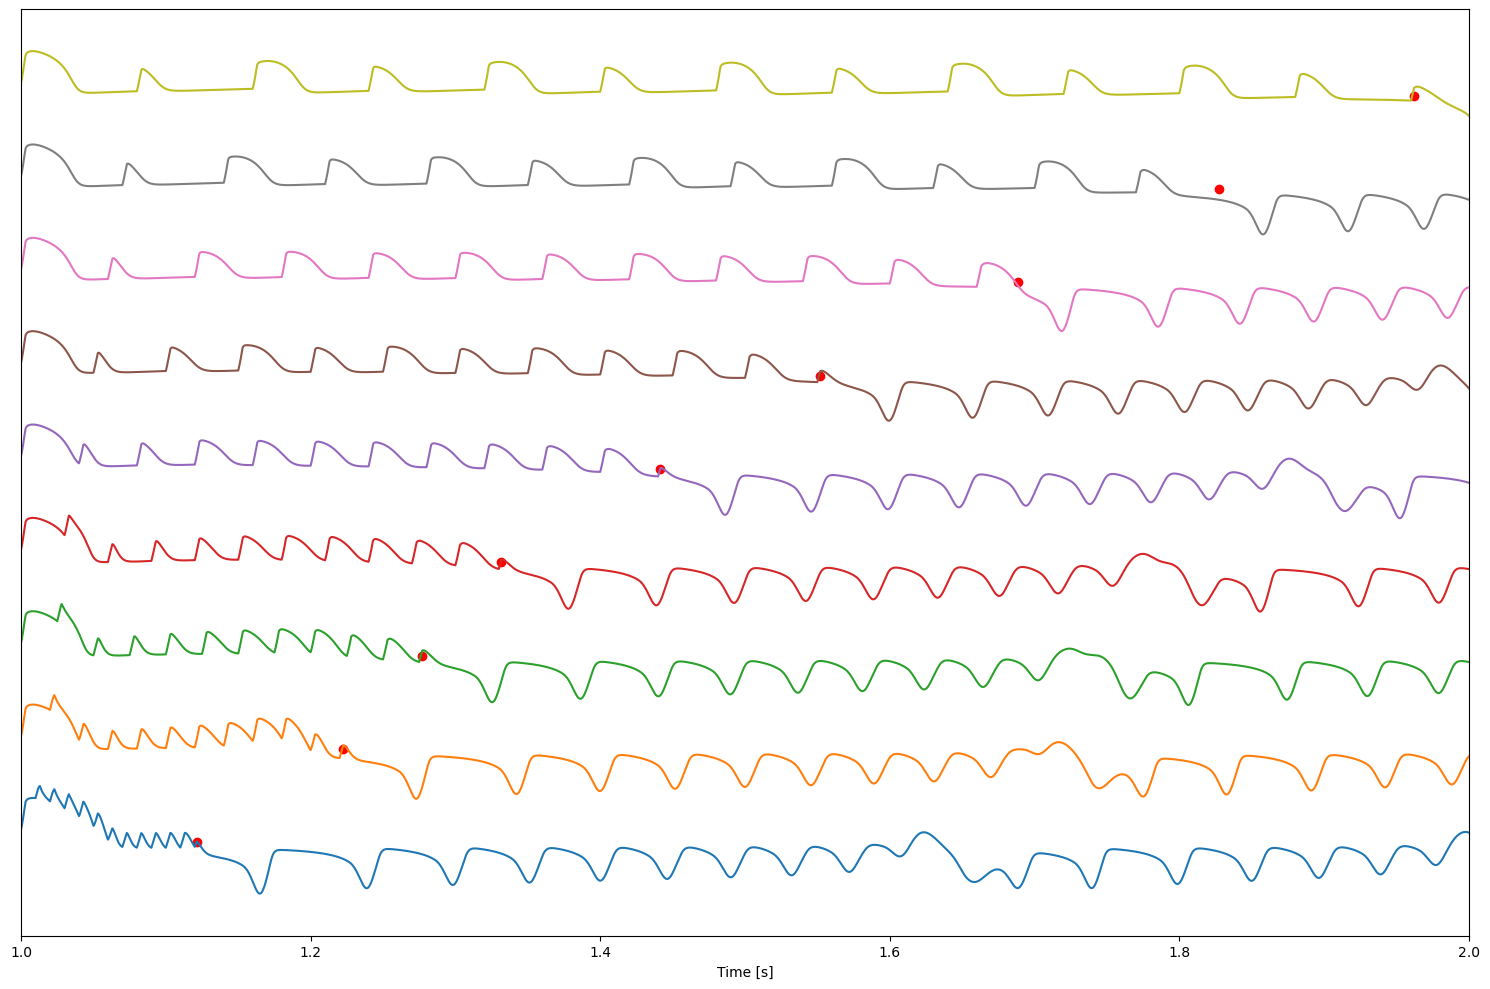

In [52]:
ts = -lllq[:, 0, :, 0] + lllq[:, 0, :, 3]
plt.figure(figsize=(15, 10))
for ifq, fq in enumerate(lI_inter[:9]):
    # time in seconds
    plt.plot(t/100, ts[ifq] + 5*ifq)
    plt.scatter(llte[ifq][0]/10000, 5*ifq, c='r')
plt.xlabel('Time [s]')
# plt.ylabel('Excitability')
# plt.title(str(Is1))
plt.yticks([])
plt.xlim([1, 2])
# plt.ylim([2, -15])
plt.tight_layout()
plt.savefig('ex.svg')



no sz
no sz
no sz
no sz
no sz
no sz
no sz


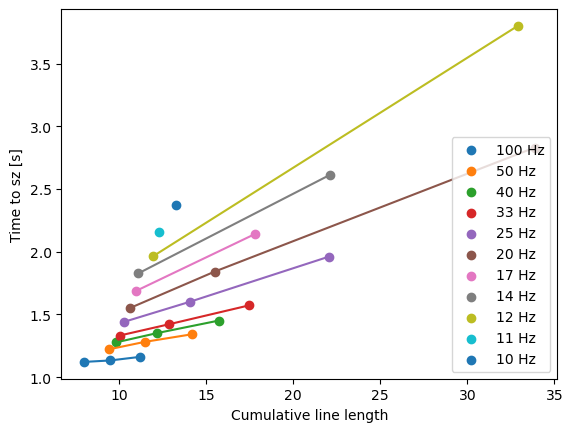

In [118]:
lfreq_stim = np.round(100/(np.array(lI_inter+I_duration))) # from 10 ms time step I_inter to freq
plt.figure()
ltime_sz, lcumll = [], []
for iI_inter, I_inter in enumerate(lI_inter[:11]):
    lte = llte[iI_inter]
    ts = -lllq[iI_inter, :, :, 0] + lllq[iI_inter, :, :, 3]
    llq = lllq[iI_inter]
    time_sz, cumll = [], []
    for ix0, x0 in enumerate(lx0):
        # ix0 = 2-ix0 # to reverse the order of plotting
        try:
            t_stim_onsets = []
            tstart_sz = np.nonzero(llq[ix0, :, 0]>-.5)[0][0]
            # print(lte[ix0])
            for i_stim in range(n_stim):
                tc = (t_start + i_stim*I_duration + i_stim*I_inter)*upsamp
                # if tc<lte[ix0]:#-1000:
                if tc<tstart_sz:#-1000:
                    t_stim_onsets.append(tc)
                    end_stim = i_stim

            dif = []
            for istim in range(len(t_stim_onsets)):
                # dif.append(np.sum(np.abs(np.diff(ts[in_stim, int(t_stim_onsets[istim]+0*upsamp):int(t_stim_onsets[istim]+5*upsamp)]))))
                dif.append(np.sum(np.abs(np.diff(ts[ix0, int(t_stim_onsets[istim]+0.*upsamp):int(t_stim_onsets[istim]+.25*upsamp)]))))

            dif_6d = []
            for istim in range(len(t_stim_onsets)):
                for idim in range(6):
                    qc = llq[ix0, int(t_stim_onsets[istim]):int(t_stim_onsets[istim]+25*upsamp), idim]
                    dif_6d.append(np.sum(np.abs(np.diff(qc))))

            dif_6dr = np.reshape(dif_6d, (len(t_stim_onsets), 6))

            cumll.append(np.sum(dif))
            time_sz.append(lte[ix0])
            lcumll.append(np.sum(dif))
            ltime_sz.append(lte[ix0])
        except:
            print('no sz')
    plt.scatter(cumll, np.array(time_sz)/(upsamp*100), label=str(int(lfreq_stim[iI_inter])) + ' Hz')
    plt.plot(cumll, np.array(time_sz)/(upsamp*100))
    plt.xlabel('Cumulative line length')
    plt.ylabel('Time to sz [s]')
    plt.legend()
    plt.savefig('diff_freq_diff_sz_onset.svg')
    
# plt.figure()
# plt.scatter(lcumll, ltime_sz/upsamp)
# plt.show()